<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_14_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICA ML Lesson 14: explainable AI (XAI) with SHAP

Welcome to our lesson on explainable AI! As scientists interested in the "why" behind phenomena, this notebook will provide an introduction to a valuable tool in your toolkit for helping to interrogate machine learning algorithms as to which factors are influencing their decisions.

We will be using the [SHAP (Shapley Additive exPlanations) library](https://github.com/slundberg/shap) to explain the output of a convolutional neural network whose purpose is to classify images of handwritten digits from the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). SHAP uses the concept of Shapley values from game theory to approximate how much each feature contributes to the learner's decision-making process.

This notebook borrows heavily from both the Keras teams' MNIST convolutional neural network (CNN) example and from Scott Lundeberg's SHAP tutorial notebook that focuses on the same materials.  You can find both at the following sites:

[Keras MNIST CNN example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)

[SHAP MNIST DeepExplainer Notebook](https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/Front%20Page%20DeepExplainer%20MNIST%20Example.ipynb)

In [1]:
# SHAP isn't default installed with Colabs, so we need to tell Google to install
# the library from PyPI.
!pip install shap

# Import all necessary libraries and items. 
from __future__ import print_function

import shap
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

# Set the plotting options to display in the notebook (for running on local machines).
%matplotlib inline

     |████████████████████████████████| 358kB 5.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491633 sha256=19ee83975691974a7285249c25006447e3ba2cb367615739bd047d6629dd3f90
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


## Training the CNN

We're going to train a convolutional neural network on the famous MNIST handwritten digits data set. We'll be using the Keras deep learning library, which is one of the most user-friendly deep learning libraries out there.

If you're keen to learn more about [Keras](https://keras.io/) or the library which it's built on top of, [TensorFlow](https://www.tensorflow.org/), then be sure to check out their websites. They have great documentation and examples for learning.

This step takes 15-20 minutes, so hit execute and grab the popcorn.

In [11]:
# Set batch size, the number of classes, and the number of training epochs for
# our CNN. For more info on these quanitites, check back to our previous lecture
# on deep neural networks.
batch_size = 256
num_classes = 10
epochs = 12

# Input image dimensions.
img_rows, img_cols = 28, 28

# Split the data up between train and test sets.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Initialize, construct, and then train our CNN.
model_ADAM = Sequential()
model_ADAM.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=input_shape,))
model_ADAM.add(Conv2D(64, (3, 3), activation='relu'))
model_ADAM.add(MaxPooling2D(pool_size=(2, 2)))
model_ADAM.add(Dropout(0.25))
model_ADAM.add(Flatten())
model_ADAM.add(Dense(128, activation='relu'))
model_ADAM.add(Dropout(0.5))
model_ADAM.add(Dense(num_classes, activation='softmax'))

model_ADAM.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(0.001),#tf.keras.optimizers.Adadelta(),
          metrics=['accuracy'])

model_ADAM.fit(x_train, y_train,
          steps_per_epoch = x_train.shape[0]//batch_size,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data=(x_test, y_test),validation_steps=x_test.shape[0]//batch_size)
score = model_ADAM.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
234/234 [==============================] - 138s 584ms/step - loss: 0.6038 - accuracy: 0.8081 - val_loss: 0.0614 - val_accuracy: 0.9820
Epoch 2/12
234/234 [==============================] - 136s 583ms/step - loss: 0.1047 - accuracy: 0.9686 - val_loss: 0.0367 - val_accuracy: 0.9875
Epoch 3/12
234/234 [==============================] - 137s 586ms/step - loss: 0.0719 - accuracy: 0.9785 - val_loss: 0.0361 - val_accuracy: 0.9879
Epoch 4/12
234/234 [==============================] - 136s 582ms/step - loss: 0.0573 - accuracy: 0.9829 - val_loss: 0.0335 - val_accuracy: 0.9885
Epoch 5/12
234/234 [==============================] - 136s 582ms/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 0.0305 - val_accuracy: 0.9894
Epoch 6/12
234/234 [==============================] - 135s 579ms/step - loss: 0.0420 - accuracy: 0.9873 - val_loss: 0.0301 - val_acc

# Using SHAP to explain our deep learning classifier

In the following section we will use [_shap_](https://github.com/slundberg/shap) to understand how the deep neural network that we just constructed and trained uses information in each image to make its decision as to which digit each image represents.

In the resulting plot, we'll the pixels will be shaded according to their SHAP values. 

A **red** pixel indicates that the classifier used the information in that pixel to weight the outcome towards a certain class.

A **blue** pixel indicates that the information contained in that pixel influenced the classifier away from the class in question.

A **white** pixel indicates that the information contained was not helpful in influencing the classifier either towards or against that class.

The **intensity** of the pixel's red- or blue-hue indicates how heavily the information in that pixel helped to influence the classifier's prediction. A **dark red** or **dark blue** pixel means that it was key to the classifier's decision to classify the image the way it did. **Lighter pixels** mean that the classifier used the information contained, but that it wasn't decisive with regards to the model's final output for that sample image.

In [12]:
# Select a set of background examples over which to calculate SHAP expectation values.
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Ask SHAP to explain predictions of the model on several images.
explainer = shap.DeepExplainer(model_ADAM, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


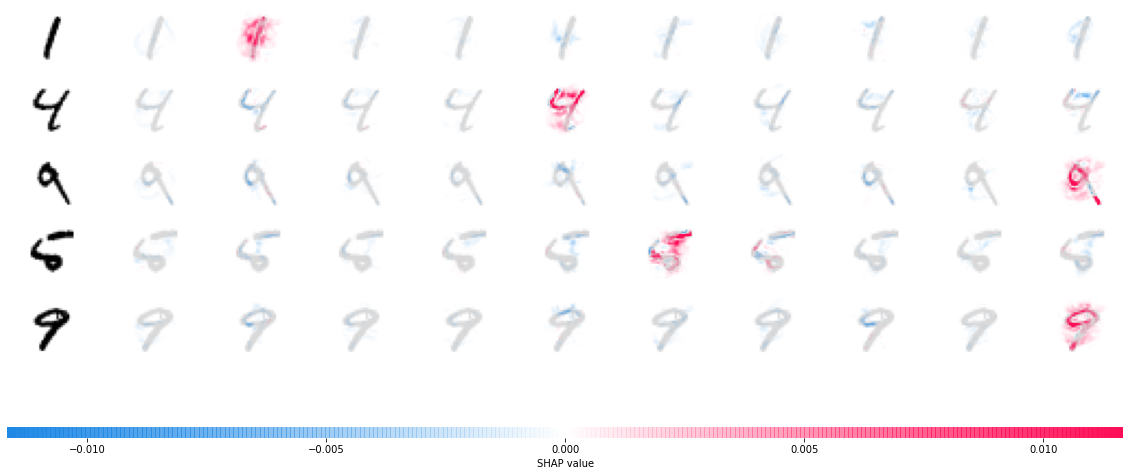

In [13]:
# Define the number of images for which you'd like to plot the SHAP values.
# Your starting and ending image indices can range from 0 to 100, since we
# asked Python to randomly select 100 images for explanation in the previous cell.
start_idx = 5
end_idx = 10

shap_values = explainer.shap_values(x_test[start_idx:end_idx])

# Plot the SHAP values on a pixel-by-pixel basis.
shap.image_plot(shap_values, -x_test[start_idx:end_idx])

In the above plot, the first column on the left displays **the image being explained**. Each column represents a different digit class: from left to right, these classes are **0-9**, respectively. 

Thus, if a **0** is being classified, you would expect: 

1.   An image of a handwritten **0** in the left column;
2.   An image of the same **0**, appearing slightly translucent, in the next column, with many red pixels indicating the classifier used those pixels to correctly classify the image as a member of the **0** class;
3.   And then all the subsequent columns to the right with slight blue shadings, indicating that the classifier detected mismatches between the handwritten digit and what it would have expected if the image were to be classified as any digit from **1-9**.